Based on:

@book{leborgne2022fraud,

title={Reproducible Machine Learning for Credit Card Fraud Detection - Practical Handbook},

author={Le Borgne, Yann-A{\"e}l and Siblini, Wissam and Lebichot, Bertrand and Bontempi, Gianluca},

url={https://github.com/Fraud-Detection-Handbook/fraud-detection-handbook},

year={2022},

publisher={Universit{\'e} Libre de Bruxelles}

}

Covered subchapters:
* 6.2 Cost-sensitive learning
* 6.3 Resampling strategies

In [15]:
import datetime
import sklearn
import time
import pickle
import imblearn
import pandas as pd

import wandb

In [2]:
%run ../shared_functions.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 63257  100 63257    0     0   176k      0 --:--:-- --:--:-- --:--:--  176k


In [23]:
%run ../my_shared_functions.py

<Figure size 640x480 with 0 Axes>

In [6]:
DIR_INPUT = '../../fraud-detection-handbook/simulated-data-transformed/data/'

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Load  files")
%time transactions_df = read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))


n_folds = 4

start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train = delta_delay = delta_test = delta_valid = delta_assessment = 7

start_date_training_for_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))
start_date_training_for_test = start_date_training+datetime.timedelta(days=(n_folds-1)*delta_test)

output_feature = "TX_FRAUD"

input_features = ['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']


# Only keep columns that are needed as argument to the custom scoring function
# (in order to reduce the serialization time of transaction dataset)
transactions_df_scorer = transactions_df[['CUSTOMER_ID', 'TX_FRAUD','TX_TIME_DAYS']]

card_precision_top_100 = sklearn.metrics.make_scorer(card_precision_top_k_custom, 
                                                     needs_proba=True, 
                                                     top_k=100, 
                                                     transactions_df=transactions_df_scorer)

performance_metrics_list_grid = ['roc_auc', 'average_precision', 'f1_score', 'card_precision@100']
performance_metrics_list = ['AUC ROC', 'Average precision', 'F1 score', 'Card Precision@100']

scoring = {'roc_auc':'roc_auc',
           'average_precision': 'average_precision',
           'f1_score': 'f1',
           'card_precision@100': card_precision_top_100,
           }

Load  files
CPU times: total: 828 ms
Wall time: 818 ms
919767 transactions loaded, containing 8195 fraudulent transactions


#### Cost-sensitive learning

##### Decision tree

In [7]:
classifier = sklearn.tree.DecisionTreeClassifier()

parameters = {'clf__max_depth':[5], 'clf__random_state':[0],
              'clf__class_weight':[{0: w} for w in [0.01, 0.05, 0.1, 0.5, 1]]}

start_time = time.time()

performances_df = model_selection_wrapper(transactions_df, classifier, 
                                          input_features, output_feature,
                                          parameters, scoring, 
                                          start_date_training_for_valid,
                                          start_date_training_for_test,
                                          n_folds=n_folds,
                                          delta_train=delta_train, 
                                          delta_delay=delta_delay, 
                                          delta_assessment=delta_assessment,
                                          performance_metrics_list_grid=performance_metrics_list_grid,
                                          performance_metrics_list=performance_metrics_list,
                                          n_jobs=1)

execution_time_dt = time.time()-start_time

In [8]:
parameters_dict = dict(performances_df['Parameters'])
performances_df['Parameters summary'] = [parameters_dict[i]['clf__class_weight'][0] for i in range(len(parameters_dict))]

performances_df_dt = performances_df

In [9]:
performances_df_dt

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,F1 score Test,F1 score Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,F1 score Validation,F1 score Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.825500,0.009464,0.537440,0.033668,0.460555,0.075778,0.289286,0.010903,"{'clf__class_weight': {0: 0.01}, 'clf__max_dep...",0.499747,0.837454,0.014356,0.532924,0.025252,0.330740,0.040295,0.277500,0.010944,0.01
1,0.792912,0.029734,0.561153,0.046031,0.599140,0.048151,0.273571,0.019418,"{'clf__class_weight': {0: 0.05}, 'clf__max_dep...",0.493882,0.808213,0.022140,0.565880,0.027737,0.574997,0.094405,0.266071,0.013716,0.05
2,0.784486,0.031698,0.556320,0.031025,0.657468,0.027592,0.272143,0.019548,"{'clf__class_weight': {0: 0.1}, 'clf__max_dept...",0.490251,0.814153,0.023492,0.572758,0.029783,0.651945,0.030503,0.269643,0.015791,0.10
3,0.798043,0.020988,0.579394,0.016007,0.688147,0.023154,0.278214,0.003093,"{'clf__class_weight': {0: 0.5}, 'clf__max_dept...",0.494749,0.799682,0.013524,0.568408,0.018631,0.689086,0.028985,0.265000,0.013420,0.50
4,0.810138,0.008586,0.600306,0.016797,0.699152,0.021309,0.284286,0.004286,"{'clf__class_weight': {0: 1}, 'clf__max_depth'...",0.490501,0.804218,0.016505,0.546094,0.042197,0.693462,0.022429,0.267857,0.013869,1.00


In [11]:
summary_performances_dt = get_summary_performances_f1_included(performances_df_dt, parameter_column_name="Parameters summary")
summary_performances_dt

,AUC ROC,Average precision,F1 score,Card Precision@100
Best estimated parameters,0.01,0.1,1.0,0.01
Validation performance,0.837+/-0.01,0.573+/-0.03,0.693+/-0.02,0.278+/-0.01
Test performance,0.825+/-0.01,0.556+/-0.03,0.699+/-0.02,0.289+/-0.01
Optimal parameter(s),0.01,1.0,1.0,0.01
Optimal test performance,0.825+/-0.01,0.6+/-0.02,0.699+/-0.02,0.289+/-0.01


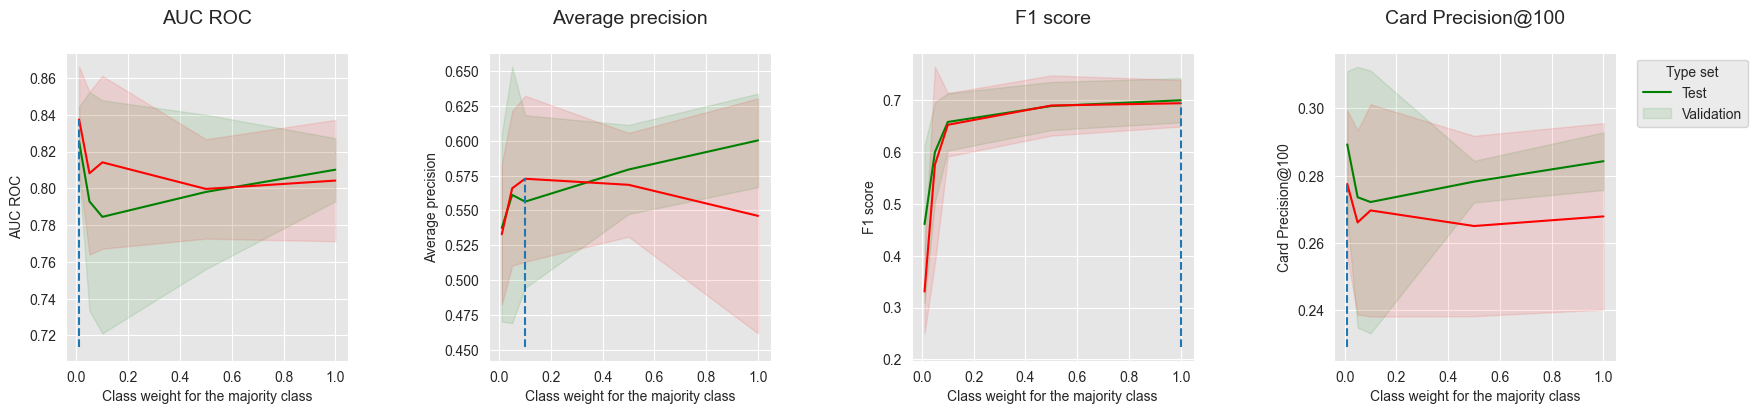

In [12]:
get_performances_plots(performances_df_dt, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'F1 score', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Class weight for the majority class",
                       summary_performances=summary_performances_dt)

In [13]:
(train_df, test_df) = get_train_test_set(transactions_df,start_date_training+datetime.timedelta(days=delta_train+delta_delay),
                                       delta_train=7,delta_delay=7,delta_test=7)

classifier = sklearn.tree.DecisionTreeClassifier(max_depth=5, class_weight={0: 0.01}, random_state=0)
model_and_predictions_dictionary = fit_model_and_get_predictions(classifier, train_df, test_df, 
                                                                 input_features, output_feature,
                                                                 scale=True)
predictions_df=test_df
predictions_df['predictions']=model_and_predictions_dictionary['predictions_test']
performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])
pickle.dump(classifier, open('../models/ML_imbalance_considered/dt_classweight_considered/dt_maxdepth5_classweight0dot01_model.sav', 'wb'))

In [16]:
config_dt = dict(
    dataset_id = 'fraud-detection-handbook-transformed',
    validation = 'prequential validation',
    begin_date = '2018-08-08',
    delta_train = 7,
    delta_delay = 7,
    delta_test = 7,
    delta_assessment = 7,
    n_folds = 4,
    random_state = 0,
    max_depth = 5,
    scale = True,
    class_weight = 0.01
)
wandb.init(project="mgr-anomaly-tsxai-project", config=config_dt, tags=['hypertuned', 'decision-tree', 'imbalance-considered'])
wandb.log({'Training execution time': model_and_predictions_dictionary['training_execution_time']})
wandb.log({'Prediction execution time':  model_and_predictions_dictionary['prediction_execution_time']})
wandb.log({'AUC ROC': performance_df.loc[0,'AUC ROC']})
wandb.log({'Average precision': performance_df.loc[0,'Average precision']})
wandb.log({'F1 score': performance_df.loc[0,'F1 score']})
wandb.log({'Card Precision@100': performance_df.loc[0,'Card Precision@100']})

dt_artifact = wandb.Artifact('dt_classweight_considered', type='decision_tree', description='trained hypertuned decision tree with class weight = 0.01 for class 0')
dt_artifact.add_dir('../models/ML_imbalance_considered/dt_classweight_considered')
wandb.log_artifact(dt_artifact)
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chamera. Use `wandb login --relogin` to force relogin


wandb: Adding directory to artifact (.\models\ML_imbalance_considered\dt_classweight_considered)... Done. 0.0s


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
AUC ROC,0.834
Average precision,0.514
Card Precision@100,0.276
F1 score,0.373
Prediction execution time,0.013


##### Logistic regression

In [17]:
classifier = sklearn.linear_model.LogisticRegression()

parameters = {'clf__C':[1], 'clf__random_state':[0],
              'clf__class_weight':[{0: w} for w in [0.01, 0.05, 0.1, 0.5, 1]]}

start_time = time.time()

performances_df = model_selection_wrapper(transactions_df, classifier, 
                                          input_features, output_feature,
                                          parameters, scoring, 
                                          start_date_training_for_valid,
                                          start_date_training_for_test,
                                          n_folds=n_folds,
                                          delta_train=delta_train, 
                                          delta_delay=delta_delay, 
                                          delta_assessment=delta_assessment,
                                          performance_metrics_list_grid=performance_metrics_list_grid,
                                          performance_metrics_list=performance_metrics_list,
                                          n_jobs=1)

execution_time_lr = time.time()-start_time

In [18]:
parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['clf__class_weight'][0] for i in range(len(parameters_dict))]

performances_df_lr=performances_df

In [19]:
performances_df_lr

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,F1 score Test,F1 score Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,F1 score Validation,F1 score Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.871396,0.017137,0.571129,0.028027,0.231824,0.022054,0.293929,0.010120,"{'clf__C': 1, 'clf__class_weight': {0: 0.01}, ...",0.304252,0.871069,0.009955,0.497808,0.039734,0.199370,0.004820,0.276429,0.013190,0.01
1,0.870711,0.016332,0.604805,0.015834,0.564592,0.025467,0.296786,0.009813,"{'clf__C': 1, 'clf__class_weight': {0: 0.05}, ...",0.329253,0.870584,0.008772,0.550617,0.029466,0.518477,0.015242,0.278571,0.015085,0.05
2,0.870083,0.016028,0.613923,0.014765,0.618842,0.025298,0.296429,0.008950,"{'clf__C': 1, 'clf__class_weight': {0: 0.1}, '...",0.331005,0.869906,0.008720,0.579392,0.019886,0.578846,0.019375,0.278214,0.014156,0.10
3,0.868234,0.015572,0.621852,0.015687,0.647131,0.021514,0.297500,0.008770,"{'clf__C': 1, 'clf__class_weight': {0: 0.5}, '...",0.355754,0.867853,0.008948,0.608950,0.023132,0.629693,0.018851,0.277143,0.015286,0.50
4,0.867643,0.015404,0.623081,0.016204,0.637389,0.034141,0.297143,0.008806,"{'clf__C': 1, 'clf__class_weight': {0: 1}, 'cl...",0.413753,0.866861,0.008988,0.612264,0.023474,0.623454,0.014004,0.278214,0.016914,1.00


In [20]:
summary_performances_lr = get_summary_performances_f1_included(performances_df_lr, parameter_column_name="Parameters summary")
summary_performances_lr

,AUC ROC,Average precision,F1 score,Card Precision@100
Best estimated parameters,0.01,1.0,0.5,0.05
Validation performance,0.871+/-0.01,0.612+/-0.02,0.63+/-0.02,0.279+/-0.02
Test performance,0.871+/-0.02,0.623+/-0.02,0.647+/-0.02,0.297+/-0.01
Optimal parameter(s),0.01,1.0,0.5,0.5
Optimal test performance,0.871+/-0.02,0.623+/-0.02,0.647+/-0.02,0.298+/-0.01


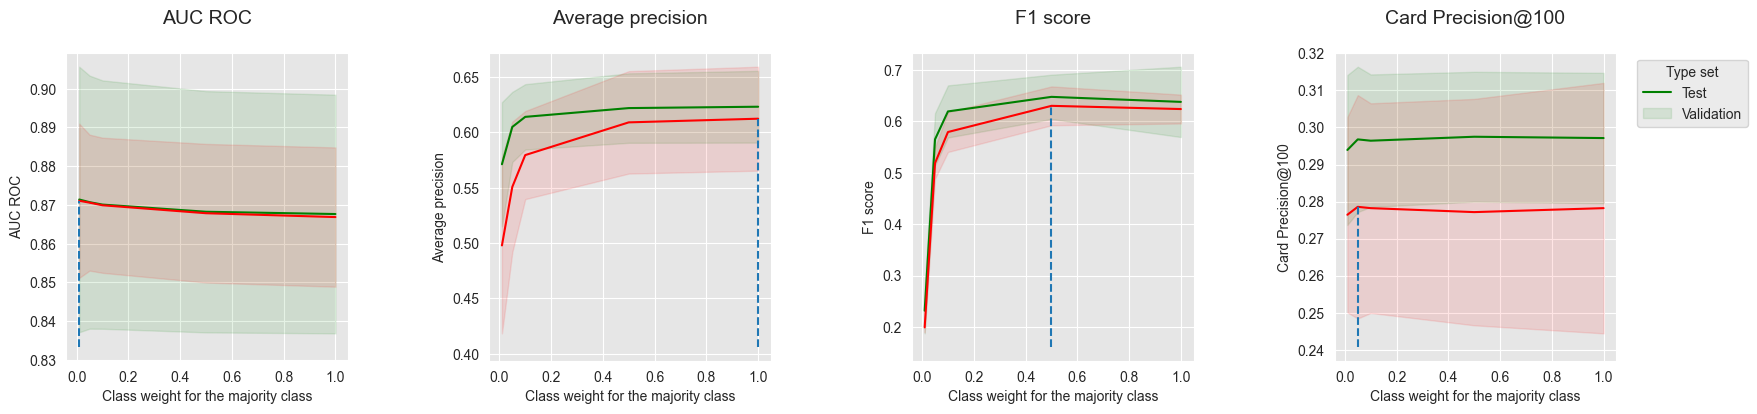

In [21]:
get_performances_plots(performances_df_lr, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'F1 score', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Class weight for the majority class",
                       summary_performances=summary_performances_lr)

#### Resampling

In [22]:
summary_performances_dt=get_summary_performances_f1_included(performances_df_dt, parameter_column_name="Parameters summary")
summary_performances_dt

,AUC ROC,Average precision,F1 score,Card Precision@100
Best estimated parameters,0.01,0.1,1.0,0.01
Validation performance,0.837+/-0.01,0.573+/-0.03,0.693+/-0.02,0.278+/-0.01
Test performance,0.825+/-0.01,0.556+/-0.03,0.699+/-0.02,0.289+/-0.01
Optimal parameter(s),0.01,1.0,1.0,0.01
Optimal test performance,0.825+/-0.01,0.6+/-0.02,0.699+/-0.02,0.289+/-0.01


##### SMOTE Oversampling

In [24]:
classifier = sklearn.tree.DecisionTreeClassifier()

sampler_list = [('sampler', imblearn.over_sampling.SMOTE(random_state=0))]

parameters = {'clf__max_depth':[5], 'clf__random_state':[0],
              'sampler__sampling_strategy':[0.01, 0.05, 0.1, 0.5, 1], 'sampler__random_state':[0]}

start_time = time.time()

performances_df=model_selection_wrapper_with_sampler(transactions_df, classifier, sampler_list, 
                                                     input_features, output_feature,
                                                     parameters, scoring, 
                                                     start_date_training_for_valid,
                                                     start_date_training_for_test,
                                                     n_folds=n_folds,
                                                     delta_train=delta_train, 
                                                     delta_delay=delta_delay, 
                                                     delta_assessment=delta_assessment,
                                                     performance_metrics_list_grid=performance_metrics_list_grid,
                                                     performance_metrics_list=performance_metrics_list,
                                                     n_jobs=1)

execution_time_dt_SMOTE = time.time()-start_time

In [25]:
parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['sampler__sampling_strategy'] for i in range(len(parameters_dict))]

performances_df_SMOTE = performances_df

In [26]:
summary_performances_SMOTE = get_summary_performances_f1_included(performances_df_SMOTE, parameter_column_name="Parameters summary")
summary_performances_SMOTE

,AUC ROC,Average precision,F1 score,Card Precision@100
Best estimated parameters,1.0,0.05,0.01,0.5
Validation performance,0.857+/-0.01,0.558+/-0.03,0.692+/-0.02,0.279+/-0.02
Test performance,0.845+/-0.01,0.573+/-0.02,0.692+/-0.03,0.289+/-0.02
Optimal parameter(s),1.0,0.01,0.01,1.0
Optimal test performance,0.845+/-0.01,0.587+/-0.01,0.692+/-0.03,0.295+/-0.01


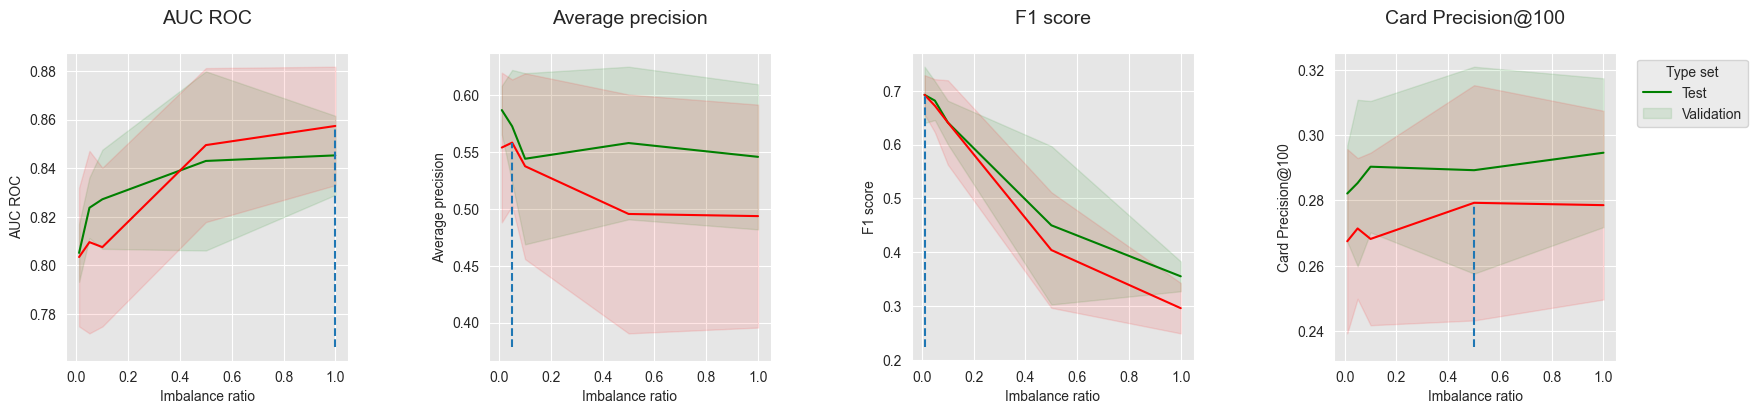

In [27]:
get_performances_plots(performances_df_SMOTE, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'F1 score', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Imbalance ratio",
                       summary_performances=summary_performances_SMOTE)

In [28]:
(train_df, test_df) = get_train_test_set(transactions_df,start_date_training+datetime.timedelta(days=delta_train+delta_delay),
                                       delta_train=7,delta_delay=7,delta_test=7)

smote = imblearn.over_sampling.SMOTE(sampling_strategy=1, random_state=0)
train_df_input_resampled, train_df_output_resampled = smote.fit_resample(train_df[input_features], train_df[output_feature])
train_df = pd.concat([train_df_input_resampled, train_df_output_resampled], axis=1)

classifier = sklearn.tree.DecisionTreeClassifier(max_depth=5, random_state=0)
model_and_predictions_dictionary = fit_model_and_get_predictions(classifier, train_df, test_df, 
                                                                 input_features, output_feature,
                                                                 scale=True)
predictions_df=test_df
predictions_df['predictions']=model_and_predictions_dictionary['predictions_test']
performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])
pickle.dump(classifier, open('../models/ML_imbalance_considered/dt_smote/dt_maxdepth5_smote1_model.sav', 'wb'))

In [29]:
config_dt = dict(
    dataset_id = 'fraud-detection-handbook-transformed',
    validation = 'prequential validation',
    begin_date = '2018-08-08',
    delta_train = 7,
    delta_delay = 7,
    delta_test = 7,
    delta_assessment = 7,
    n_folds = 4,
    random_state = 0,
    max_depth = 5,
    scale = True,
    smote_sampling_strategy = 1,
    smote_random_state = 0
)
wandb.init(project="mgr-anomaly-tsxai-project", config=config_dt, tags=['hypertuned', 'decision-tree', 'imbalance-considered'])
wandb.log({'Training execution time': model_and_predictions_dictionary['training_execution_time']})
wandb.log({'Prediction execution time':  model_and_predictions_dictionary['prediction_execution_time']})
wandb.log({'AUC ROC': performance_df.loc[0,'AUC ROC']})
wandb.log({'Average precision': performance_df.loc[0,'Average precision']})
wandb.log({'F1 score': performance_df.loc[0,'F1 score']})
wandb.log({'Card Precision@100': performance_df.loc[0,'Card Precision@100']})

dt_artifact = wandb.Artifact('dt_smote', type='decision_tree', description='trained hypertuned decision tree with smote sampling')
dt_artifact.add_dir('../models/ML_imbalance_considered/dt_smote')
wandb.log_artifact(dt_artifact)
wandb.finish()

wandb: Adding directory to artifact (.\models\ML_imbalance_considered\dt_smote)... Done. 0.0s


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
AUC ROC,0.853
Average precision,0.512
Card Precision@100,0.28
F1 score,0.363
Prediction execution time,0.01


##### Random Undersampling

In [30]:
classifier = sklearn.tree.DecisionTreeClassifier()

sampler_list = [('sampler', imblearn.under_sampling.RandomUnderSampler())]

parameters = {'clf__max_depth':[5], 'clf__random_state':[0],
              'sampler__sampling_strategy':[0.01, 0.05, 0.1, 0.5, 1], 'sampler__random_state':[0]}

start_time = time.time()

performances_df=model_selection_wrapper_with_sampler(transactions_df, classifier, sampler_list, 
                                                     input_features, output_feature,
                                                     parameters, scoring, 
                                                     start_date_training_for_valid,
                                                     start_date_training_for_test,
                                                     n_folds=n_folds,
                                                     delta_train=delta_train, 
                                                     delta_delay=delta_delay, 
                                                     delta_assessment=delta_assessment,
                                                     performance_metrics_list_grid=performance_metrics_list_grid,
                                                     performance_metrics_list=performance_metrics_list,
                                                     n_jobs=1)

execution_time_dt_RUS = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['sampler__sampling_strategy'] for i in range(len(parameters_dict))]

performances_df_RUS = performances_df

In [31]:
summary_performances_RUS=get_summary_performances_f1_included(performances_df_RUS, parameter_column_name="Parameters summary")
summary_performances_RUS

,AUC ROC,Average precision,F1 score,Card Precision@100
Best estimated parameters,1.0,0.01,0.01,0.1
Validation performance,0.845+/-0.01,0.535+/-0.04,0.69+/-0.02,0.269+/-0.01
Test performance,0.83+/-0.01,0.594+/-0.02,0.702+/-0.02,0.277+/-0.01
Optimal parameter(s),1.0,0.01,0.01,0.5
Optimal test performance,0.83+/-0.01,0.594+/-0.02,0.702+/-0.02,0.292+/-0.01


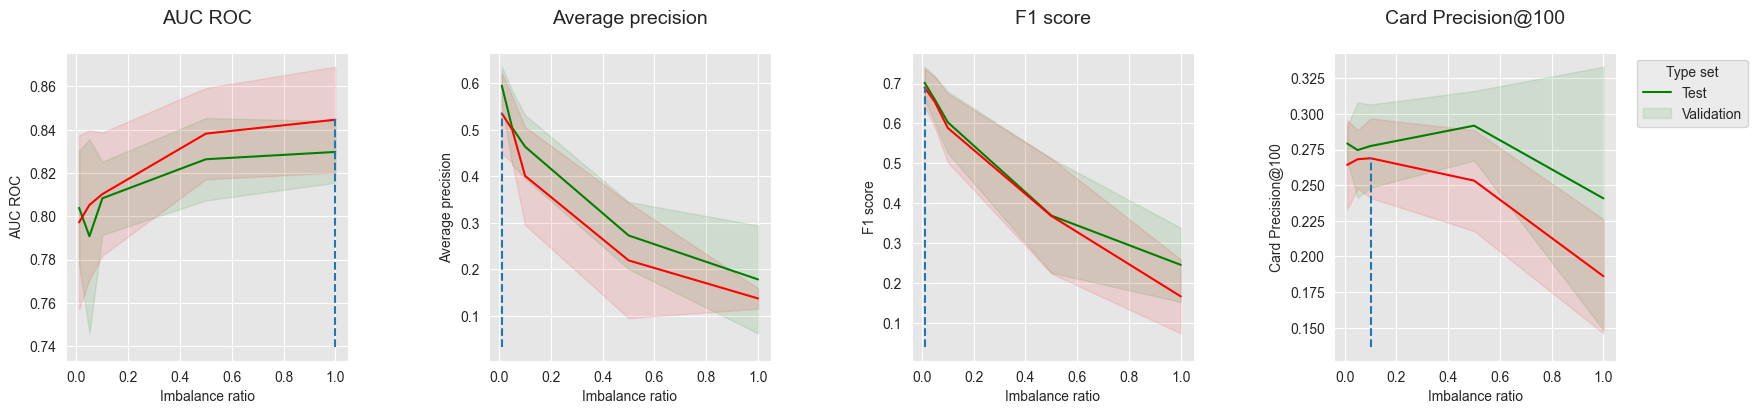

In [32]:
get_performances_plots(performances_df_RUS, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'F1 score', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Imbalance ratio",
                       summary_performances=summary_performances_RUS)

##### Combining SMOTE and Random Undersampling

In [33]:
classifier = sklearn.tree.DecisionTreeClassifier()

sampler_list = [('sampler1', imblearn.over_sampling.SMOTE()),
                ('sampler2', imblearn.under_sampling.RandomUnderSampler())
               ]

parameters = {'clf__max_depth':[5], 'clf__random_state':[0],
              'sampler1__sampling_strategy':[0.1], 
              'sampler2__sampling_strategy':[0.1, 0.5, 1], 
              'sampler1__random_state':[0], 'sampler2__random_state':[0]}

start_time = time.time()

performances_df = model_selection_wrapper_with_sampler(transactions_df, classifier, sampler_list, 
                                                     input_features, output_feature,
                                                     parameters, scoring, 
                                                     start_date_training_for_valid,
                                                     start_date_training_for_test,
                                                     n_folds=n_folds,
                                                     delta_train=delta_train, 
                                                     delta_delay=delta_delay, 
                                                     delta_assessment=delta_assessment,
                                                     performance_metrics_list_grid=performance_metrics_list_grid,
                                                     performance_metrics_list=performance_metrics_list,
                                                     n_jobs=1)

execution_time_dt_combined = time.time()-start_time

parameters_dict = dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['sampler2__sampling_strategy'] for i in range(len(parameters_dict))]

performances_df_combined = performances_df

In [34]:
performances_df_combined

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,F1 score Test,F1 score Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,F1 score Validation,F1 score Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.827219,0.010190,0.544275,0.037686,0.640891,0.020209,0.290357,0.010070,"{'clf__max_depth': 5, 'clf__random_state': 0, ...",0.601750,0.807543,0.016324,0.537672,0.040918,0.640915,0.039168,0.268214,0.013224,0.1
1,0.848464,0.008701,0.471467,0.010144,0.405927,0.068665,0.299643,0.011968,"{'clf__max_depth': 5, 'clf__random_state': 0, ...",0.383958,0.841237,0.015297,0.428576,0.050091,0.367251,0.054860,0.279286,0.010903,0.5
2,0.847110,0.010754,0.385133,0.064916,0.281276,0.051442,0.287857,0.018364,"{'clf__max_depth': 5, 'clf__random_state': 0, ...",0.350752,0.856399,0.012189,0.342964,0.020342,0.273801,0.033005,0.280357,0.017420,1.0


In [35]:
summary_performances_combined = get_summary_performances_f1_included(performances_df=performances_df_combined, 
                                                         parameter_column_name="Parameters summary")
summary_performances_combined

,AUC ROC,Average precision,F1 score,Card Precision@100
Best estimated parameters,1.0,0.1,0.1,1.0
Validation performance,0.856+/-0.01,0.538+/-0.04,0.641+/-0.04,0.28+/-0.02
Test performance,0.847+/-0.01,0.544+/-0.04,0.641+/-0.02,0.288+/-0.02
Optimal parameter(s),0.5,0.1,0.1,0.5
Optimal test performance,0.848+/-0.01,0.544+/-0.04,0.641+/-0.02,0.3+/-0.01


In [36]:
(train_df, test_df) = get_train_test_set(transactions_df,start_date_training+datetime.timedelta(days=delta_train+delta_delay),
                                       delta_train=7,delta_delay=7,delta_test=7)

smote = imblearn.over_sampling.SMOTE(sampling_strategy=0.1, random_state=0)
train_df_input_resampled, train_df_output_resampled = smote.fit_resample(train_df[input_features], train_df[output_feature])
rus = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=1, random_state=0)
train_df_input_resampled, train_df_output_resampled = rus.fit_resample(train_df_input_resampled, train_df_output_resampled)
train_df = pd.concat([train_df_input_resampled, train_df_output_resampled], axis=1)

classifier = sklearn.tree.DecisionTreeClassifier(max_depth=5, random_state=0)
model_and_predictions_dictionary = fit_model_and_get_predictions(classifier, train_df, test_df, 
                                                                 input_features, output_feature,
                                                                 scale=True)
predictions_df=test_df
predictions_df['predictions']=model_and_predictions_dictionary['predictions_test']
performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])
pickle.dump(classifier, open('../models/ML_imbalance_considered/dt_smote_randunder/dt_maxdepth5_smote0dot1_randundersampl1_model.sav', 'wb'))

In [37]:
config_dt = dict(
    dataset_id = 'fraud-detection-handbook-transformed',
    validation = 'prequential validation',
    begin_date = '2018-08-08',
    delta_train = 7,
    delta_delay = 7,
    delta_test = 7,
    delta_assessment = 7,
    n_folds = 4,
    random_state = 0,
    max_depth = 5,
    scale = True,
    smote_sampling_strategy = 0.1,
    smote_random_state = 0,
    randomundersampler_sampling_strategy = 1,
    randomundersampler_random_state = 0,
)
wandb.init(project="mgr-anomaly-tsxai-project", config=config_dt, tags=['hypertuned', 'decision-tree', 'imbalance-considered'])
wandb.log({'Training execution time': model_and_predictions_dictionary['training_execution_time']})
wandb.log({'Prediction execution time':  model_and_predictions_dictionary['prediction_execution_time']})
wandb.log({'AUC ROC': performance_df.loc[0,'AUC ROC']})
wandb.log({'Average precision': performance_df.loc[0,'Average precision']})
wandb.log({'F1 score': performance_df.loc[0,'F1 score']})
wandb.log({'Card Precision@100': performance_df.loc[0,'Card Precision@100']})

dt_artifact = wandb.Artifact('dt_smote_randunder', type='decision_tree', description='trained hypertuned decision tree with smote sampling and random undersampling combined')
dt_artifact.add_dir('../models/ML_imbalance_considered/dt_smote_randunder')
wandb.log_artifact(dt_artifact)
wandb.finish()

wandb: Adding directory to artifact (.\models\ML_imbalance_considered\dt_smote_randunder)... Done. 0.0s


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
AUC ROC,0.847
Average precision,0.356
Card Precision@100,0.261
F1 score,0.26
Prediction execution time,0.012


##### Comparison

In [38]:
summary_test_performances = pd.concat([summary_performances_dt.iloc[2,:],
                                       summary_performances_SMOTE.iloc[2,:],
                                       summary_performances_RUS.iloc[2,:],
                                       summary_performances_combined.iloc[2,:],
                                      ],axis=1)
summary_test_performances.columns=['Baseline', 'SMOTE', 'RUS', 'Combined']
summary_test_performances

,Baseline,SMOTE,RUS,Combined
AUC ROC,0.825+/-0.01,0.845+/-0.01,0.83+/-0.01,0.847+/-0.01
Average precision,0.556+/-0.03,0.573+/-0.02,0.594+/-0.02,0.544+/-0.04
F1 score,0.699+/-0.02,0.692+/-0.03,0.702+/-0.02,0.641+/-0.02
Card Precision@100,0.289+/-0.01,0.289+/-0.02,0.277+/-0.01,0.288+/-0.02
